# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:

import statsmodels.api as sm
from datetime import date

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [8]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

# The Data

In [9]:
wfc = pd.read_csv('Dataset/WFC Daily1.csv')

In [10]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [11]:
wfc.Date.dtype

dtype('O')

In [12]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [13]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [14]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5754 non-null   datetime64[ns]
 1   Open       5754 non-null   float64       
 2   High       5754 non-null   float64       
 3   Low        5754 non-null   float64       
 4   Close      5754 non-null   float64       
 5   Adj Close  5754 non-null   float64       
 6   Volume     5754 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


In [15]:
wfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,36.78,35.98,36.38,28.01,24313450.19
std,11.74,11.77,11.73,11.75,12.85,26705062.78
min,8.65,8.94,7.80,8.12,5.76,1774000.00
25%,26.71,27.20,26.25,26.74,18.01,10091200.00
50%,32.65,33.13,32.25,32.64,23.18,17086600.00
75%,47.75,48.19,47.33,47.79,41.58,29145250.00
max,65.89,66.31,65.66,65.93,57.96,478736600.00


In [16]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999324,0.999274,0.998754,0.965403,-0.184389
High,0.999324,1.000000,0.998796,0.999323,0.967945,-0.169457
Low,0.999274,0.998796,1.000000,0.999303,0.963519,-0.199335
Close,0.998754,0.999323,0.999303,1.000000,0.966149,-0.183272
Adj Close,0.965403,0.967945,0.963519,0.966149,1.000000,-0.080189
Volume,-0.184389,-0.169457,-0.199335,-0.183272,-0.080189,1.000000


# The Split

In [17]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [18]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [19]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [20]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 7)
Train dataset shape: (4313, 7)
Vaid dataset shape: (692, 7)
Test dataset shape: (749, 7)


# Stock Price Graph

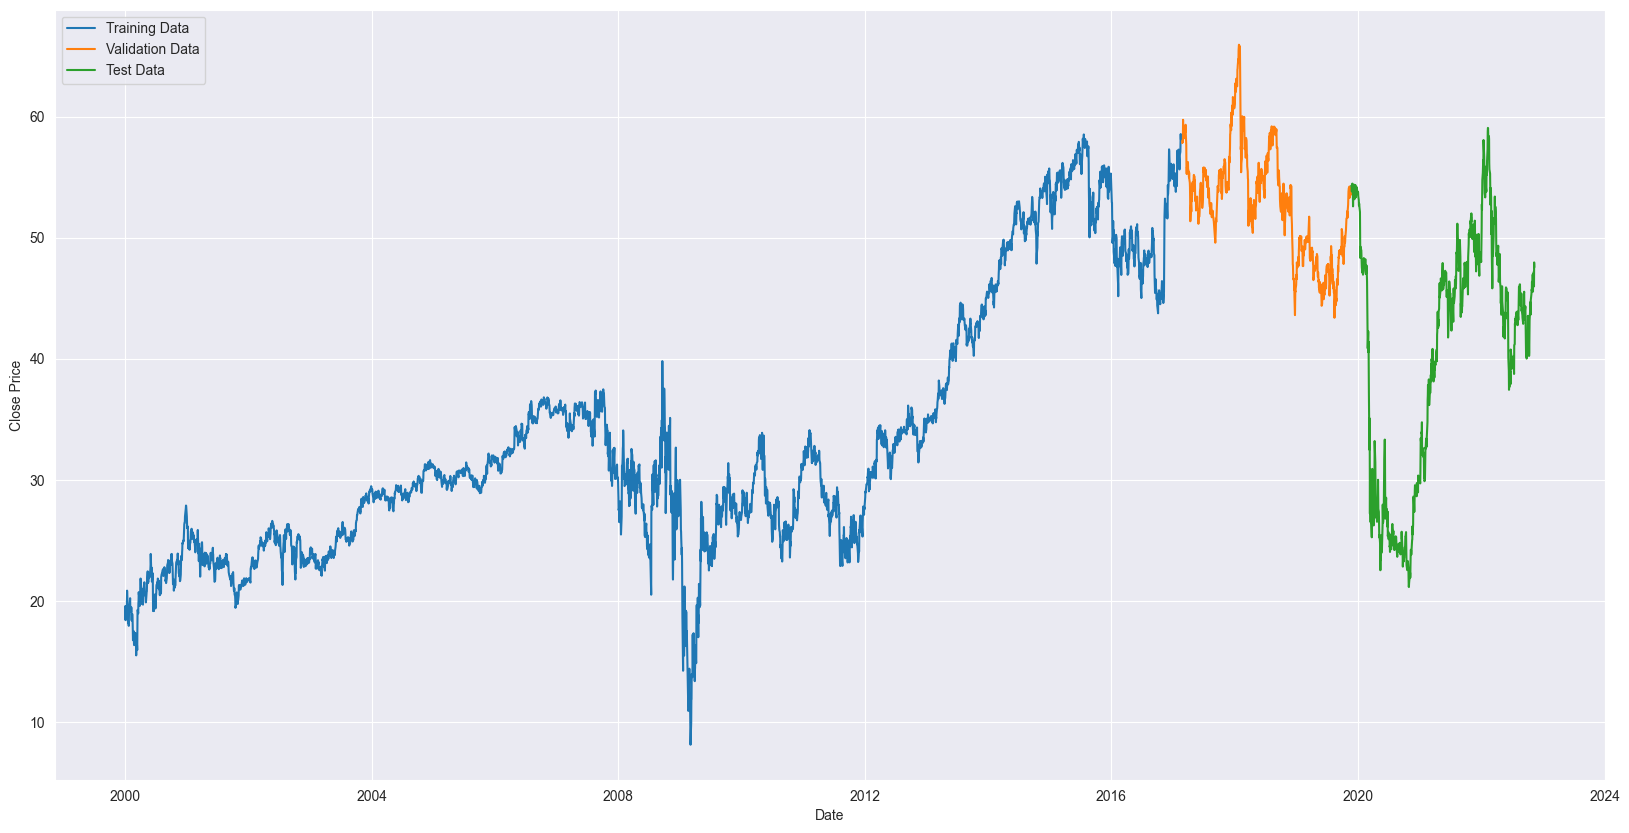

In [21]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

In [22]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [23]:
trainNorm = train_df.Close.values.reshape(-1, 1)
testNorm = test_df.Close.values.reshape(-1, 1)
validNorm = valid_df.Close.values.reshape(-1, 1)

In [24]:
trainNorm.shape

(4313, 1)

## Windowed Dataset

In [25]:
mse_arr=[]
Z = []

window = 50

In [26]:
X_train= []
Y_train=[]
X_valid= []
Y_valid=[]
X_test= []
Y_test=[]

for i in range(len(trainNorm) - (window)):
    X_train.append(trainNorm[i:i+window])
    Y_train.append(trainNorm[i+window])
    
for i in range(len(validNorm) - (window)):
    X_valid.append(validNorm[i:i+window])
    Y_valid.append(validNorm[i+window])
    
for i in range(len(testNorm) - (window)):
    X_test.append(testNorm[i:i+window])
    Y_test.append(testNorm[i+window])
    

X_train=np.asanyarray(X_train)
Y_train=np.asanyarray(Y_train)
X_valid=np.asanyarray(X_valid)
Y_valid=np.asanyarray(Y_valid)
X_test=np.asanyarray(X_test)
Y_test=np.asanyarray(Y_test)

Xtrain = X_train[:,:,:]  
Ytrain = Y_train[:]  
Xvalid = X_valid[:,:,:]  
Yvalid= Y_valid[:]  
Xtest = X_test[:,:,:]  
Ytest= Y_test[:]  

# Model Building

In [27]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [28]:
model.add(keras.layers.SimpleRNN(40, return_sequences = True))
model.add(keras.layers.SimpleRNN(40))
model.add(tf.keras.layers.Dense(1))

## Optimizing Learning Rate

In [29]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [30]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer = Adam(1e-8),
             metrics = ["mae"])

In [31]:
history = model.fit(Xtrain,Ytrain,batch_size=128, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
34/34 [==============================] - 7s 126ms/step - loss: 1279.0516 - mae: 34.2789 - lr: 1.0000e-08
Epoch 2/500
34/34 [==============================] - 5s 136ms/step - loss: 1279.0425 - mae: 34.2788 - lr: 1.1220e-08
Epoch 3/500
34/34 [==============================] - 4s 130ms/step - loss: 1279.0325 - mae: 34.2786 - lr: 1.2589e-08
Epoch 4/500
34/34 [==============================] - 5s 134ms/step - loss: 1279.0225 - mae: 34.2785 - lr: 1.4125e-08
Epoch 5/500
34/34 [==============================] - 5s 144ms/step - loss: 1279.0104 - mae: 34.2783 - lr: 1.5849e-08
Epoch 6/500
34/34 [==============================] - 5s 138ms/step - loss: 1278.9963 - mae: 34.2781 - lr: 1.7783e-08
Epoch 7/500
34/34 [==============================] - 5s 144ms/step - loss: 1278.9814 - mae: 34.2779 - lr: 1.9953e-08
Epoch 8/500
34/34 [==============================] - 5s 143ms/step - loss: 1278.9639 - mae: 34.2776 - lr: 2.2387e-08
Epoch 9/500
34/34 [==============================] - 5s 144ms/st

34/34 [==============================] - 4s 115ms/step - loss: 1060.8757 - mae: 30.9195 - lr: 2.8184e-05
Epoch 71/500
34/34 [==============================] - 4s 113ms/step - loss: 1036.6095 - mae: 30.5281 - lr: 3.1623e-05
Epoch 72/500
34/34 [==============================] - 4s 120ms/step - loss: 1010.1102 - mae: 30.0947 - lr: 3.5481e-05
Epoch 73/500
34/34 [==============================] - 4s 131ms/step - loss: 984.2781 - mae: 29.6662 - lr: 3.9811e-05
Epoch 74/500
34/34 [==============================] - 5s 137ms/step - loss: 961.8383 - mae: 29.2875 - lr: 4.4668e-05
Epoch 75/500
34/34 [==============================] - 5s 135ms/step - loss: 942.9147 - mae: 28.9632 - lr: 5.0119e-05
Epoch 76/500
34/34 [==============================] - 4s 130ms/step - loss: 926.3394 - mae: 28.6742 - lr: 5.6234e-05
Epoch 77/500
34/34 [==============================] - 4s 131ms/step - loss: 910.9966 - mae: 28.4052 - lr: 6.3096e-05
Epoch 78/500
34/34 [==============================] - 4s 132ms/step - loss

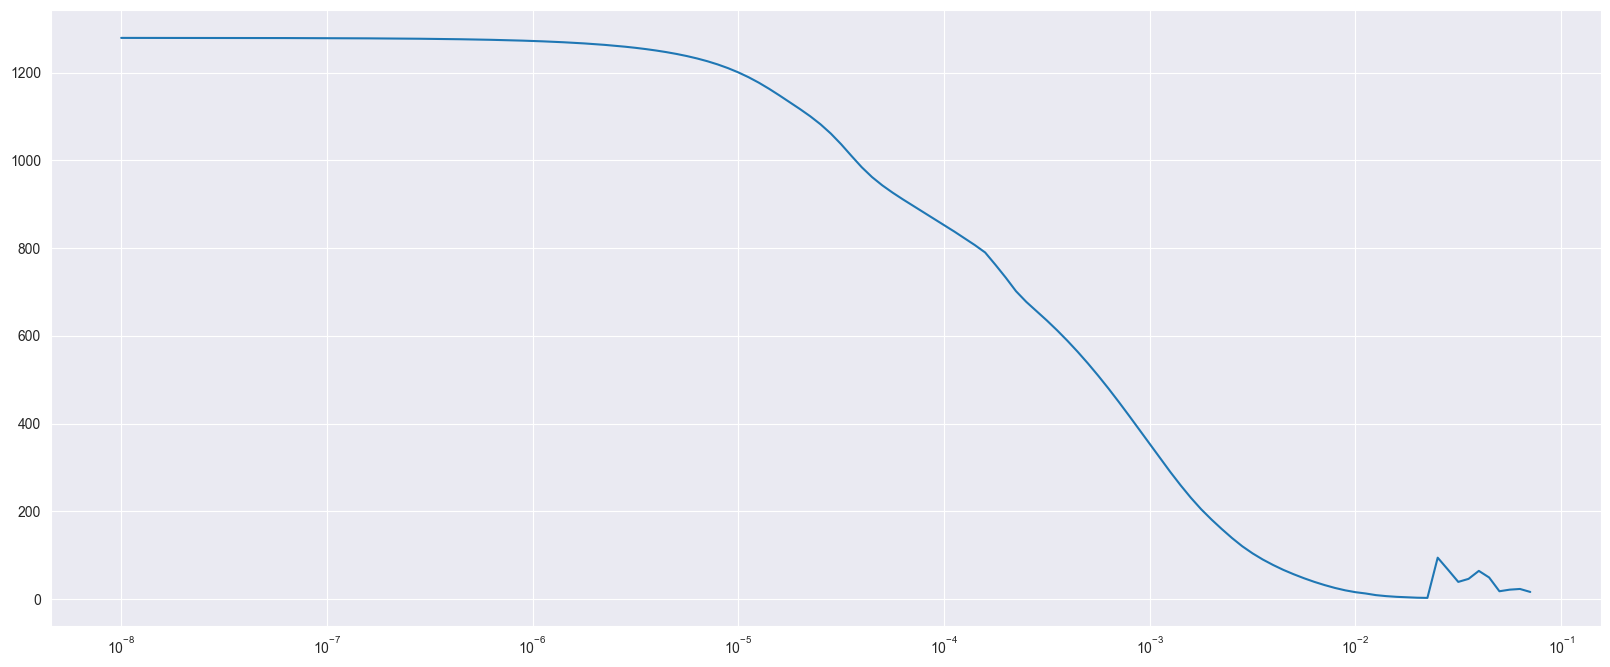

In [32]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 30])

(0.001, 0.1, 0.0, 200.0)

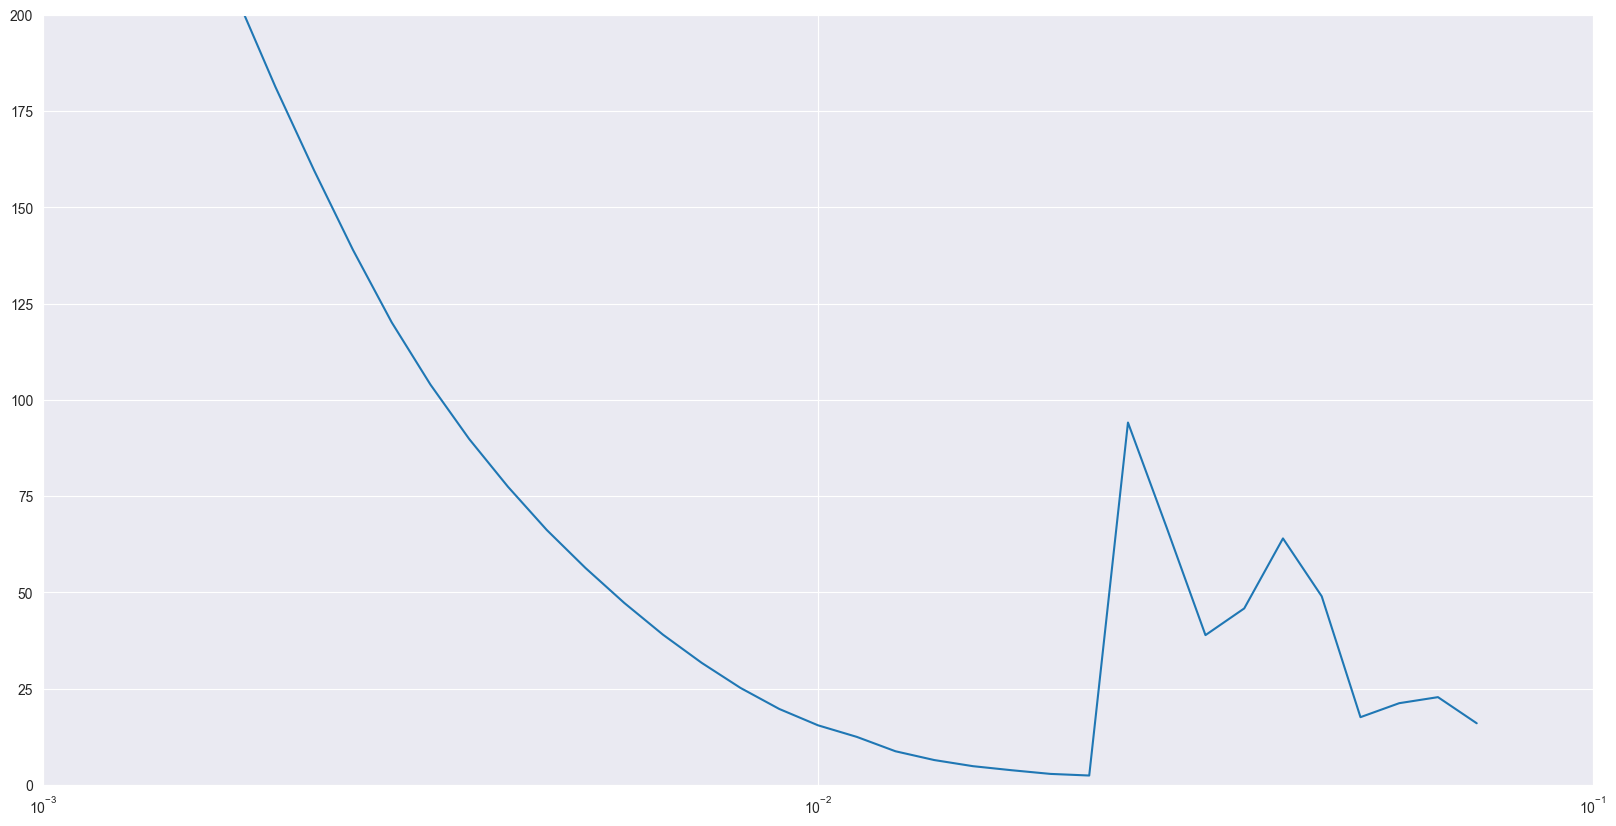

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-1, 0, 200])

In [34]:
end()

NameError: name 'end' is not defined

## Final Model Build

In [35]:
tf.keras.backend.clear_session()

In [36]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(9e-3),
              metrics=['mae'])

In [37]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")

tensorboard_callback = [
#                         tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#                         ModelCheckpoint(model_path, verbose=1, save_best_only=True),
#                         ReduceLROnPlateau(monitor= "val_mae", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
                        ReduceLROnPlateau(monitor='val_mae', factor=0.2,patience=5, min_lr=1e-6, verbose=1),
#                         CSVLogger(csv_path),
                        TensorBoard(),
                        EarlyStopping(monitor= "val_mae", patience=10, restore_best_weights=True)
                       ]

In [38]:
history = model.fit(Xtrain, Ytrain,batch_size=128, epochs=500, verbose=1,validation_data=(Xvalid, Yvalid), callbacks=tensorboard_callback)

Epoch 1/500
34/34 [==============================] - 7s 152ms/step - loss: 33.3033 - mae: 3.0081 - val_loss: 22.4830 - val_mae: 3.5561 - lr: 0.0090
Epoch 2/500
34/34 [==============================] - 5s 137ms/step - loss: 2.2571 - mae: 0.9036 - val_loss: 12.8809 - val_mae: 2.3817 - lr: 0.0090
Epoch 3/500
34/34 [==============================] - 5s 141ms/step - loss: 1.2049 - mae: 0.6640 - val_loss: 8.1388 - val_mae: 1.7525 - lr: 0.0090
Epoch 4/500
34/34 [==============================] - 5s 147ms/step - loss: 0.8081 - mae: 0.5581 - val_loss: 6.1245 - val_mae: 1.4692 - lr: 0.0090
Epoch 5/500
34/34 [==============================] - 5s 148ms/step - loss: 0.6957 - mae: 0.5365 - val_loss: 5.1387 - val_mae: 1.3321 - lr: 0.0090
Epoch 6/500
34/34 [==============================] - 5s 150ms/step - loss: 0.6733 - mae: 0.5438 - val_loss: 4.3938 - val_mae: 1.1915 - lr: 0.0090
Epoch 7/500
34/34 [==============================] - 5s 146ms/step - loss: 0.6341 - mae: 0.5270 - val_loss: 4.0324 - val_

Epoch 56/500
34/34 [==============================] - 5s 137ms/step - loss: 0.4450 - mae: 0.4448 - val_loss: 2.0537 - val_mae: 0.9180 - lr: 0.0018
Epoch 57/500
34/34 [==============================] - 5s 140ms/step - loss: 0.4299 - mae: 0.4286 - val_loss: 1.8069 - val_mae: 0.7558 - lr: 0.0018
Epoch 58/500
34/34 [==============================] - 5s 141ms/step - loss: 0.4260 - mae: 0.4273 - val_loss: 1.7969 - val_mae: 0.7562 - lr: 0.0018
Epoch 59/500
34/34 [==============================] - 5s 140ms/step - loss: 0.4476 - mae: 0.4441 - val_loss: 1.8457 - val_mae: 0.7833 - lr: 0.0018
Epoch 60/500
34/34 [==============================] - 5s 146ms/step - loss: 0.4397 - mae: 0.4396 - val_loss: 1.8188 - val_mae: 0.7853 - lr: 0.0018
Epoch 61/500
34/34 [==============================] - 5s 147ms/step - loss: 0.4404 - mae: 0.4429 - val_loss: 1.8005 - val_mae: 0.7610 - lr: 0.0018
Epoch 62/500
34/34 [==============================] - ETA: 0s - loss: 0.4289 - mae: 0.4286
Epoch 62: ReduceLROnPlateau

34/34 [==============================] - 5s 152ms/step - loss: 0.4070 - mae: 0.4112 - val_loss: 1.7065 - val_mae: 0.7389 - lr: 7.2000e-05
Epoch 109/500
34/34 [==============================] - ETA: 0s - loss: 0.4070 - mae: 0.4115
Epoch 109: ReduceLROnPlateau reducing learning rate to 1.4400000509340316e-05.
34/34 [==============================] - 5s 147ms/step - loss: 0.4070 - mae: 0.4115 - val_loss: 1.7143 - val_mae: 0.7443 - lr: 7.2000e-05
Epoch 110/500
34/34 [==============================] - 5s 146ms/step - loss: 0.4070 - mae: 0.4114 - val_loss: 1.7054 - val_mae: 0.7387 - lr: 1.4400e-05
Epoch 111/500
34/34 [==============================] - 5s 147ms/step - loss: 0.4060 - mae: 0.4105 - val_loss: 1.7049 - val_mae: 0.7385 - lr: 1.4400e-05
Epoch 112/500
34/34 [==============================] - 5s 150ms/step - loss: 0.4061 - mae: 0.4104 - val_loss: 1.7047 - val_mae: 0.7384 - lr: 1.4400e-05
Epoch 113/500
34/34 [==============================] - 5s 149ms/step - loss: 0.4059 - mae: 0.4103

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


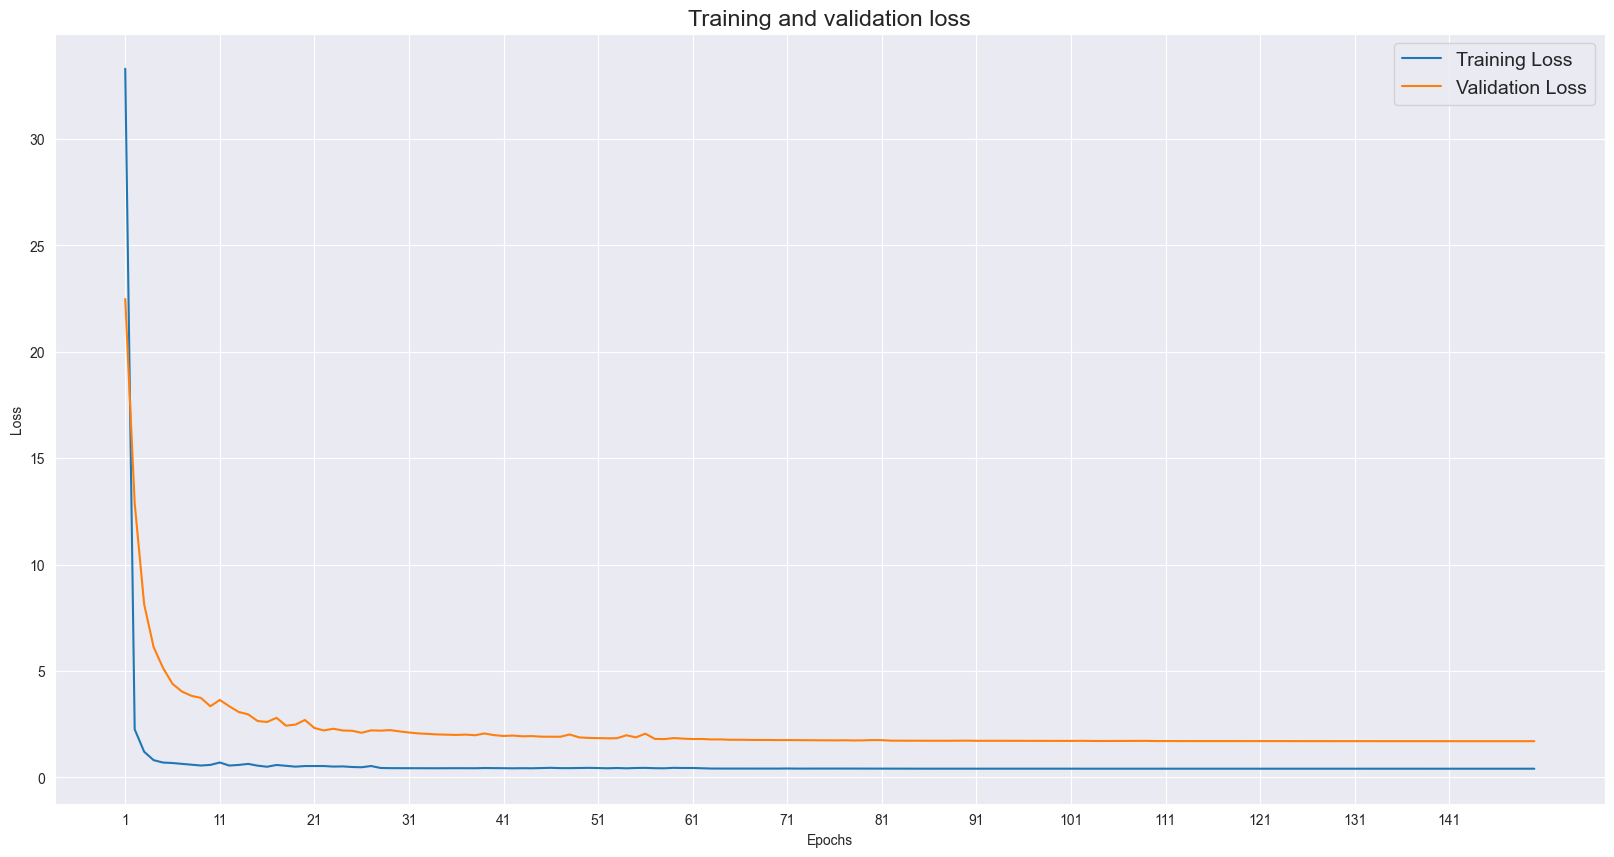

In [40]:
#Showing training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, label='Training Loss')
plt.plot(epochs, val_loss_values50, label='Validation Loss')
plt.rc('font', size = 14)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 10.0))
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

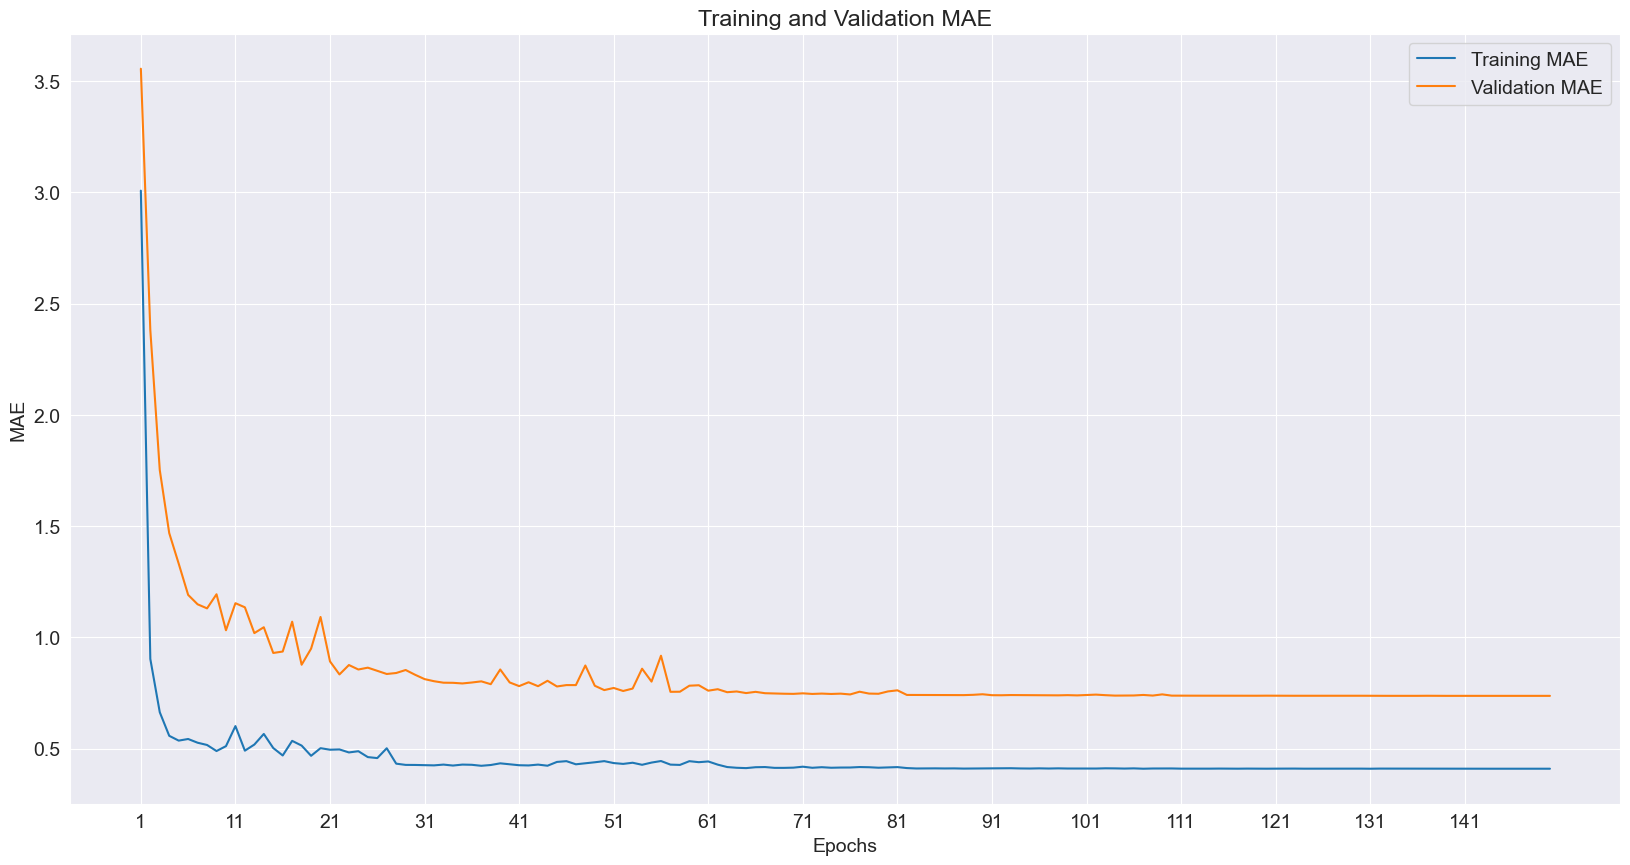

In [41]:
loss_values = history_dict['mae']
val_loss_values = history_dict['val_mae']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, label='Training MAE')
plt.plot(epochs, val_loss_values50, label='Validation MAE')
plt.rc('font', size = 14)
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.xticks(epochs)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 10.0))
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

In [42]:
#Evaluating model
trainScore = model.evaluate(Xtrain, Ytrain, verbose=1)
validScore = model.evaluate(Xvalid, Yvalid, verbose=1)
testScore = model.evaluate(Xtest, Ytest, verbose=1)

22/22 [==============================] - 0s 20ms/step - loss: 1.1344 - mae: 0.7810


In [43]:
testScore, validScore, trainScore

([1.1343845129013062, 0.7809885740280151],
 [1.6996893882751465, 0.7376199960708618],
 [0.40552568435668945, 0.41014131903648376])

In [44]:
preds = model.predict(Xtest)

22/22 [==============================] - 1s 22ms/step


In [45]:
Xtest.shape

(699, 50, 1)

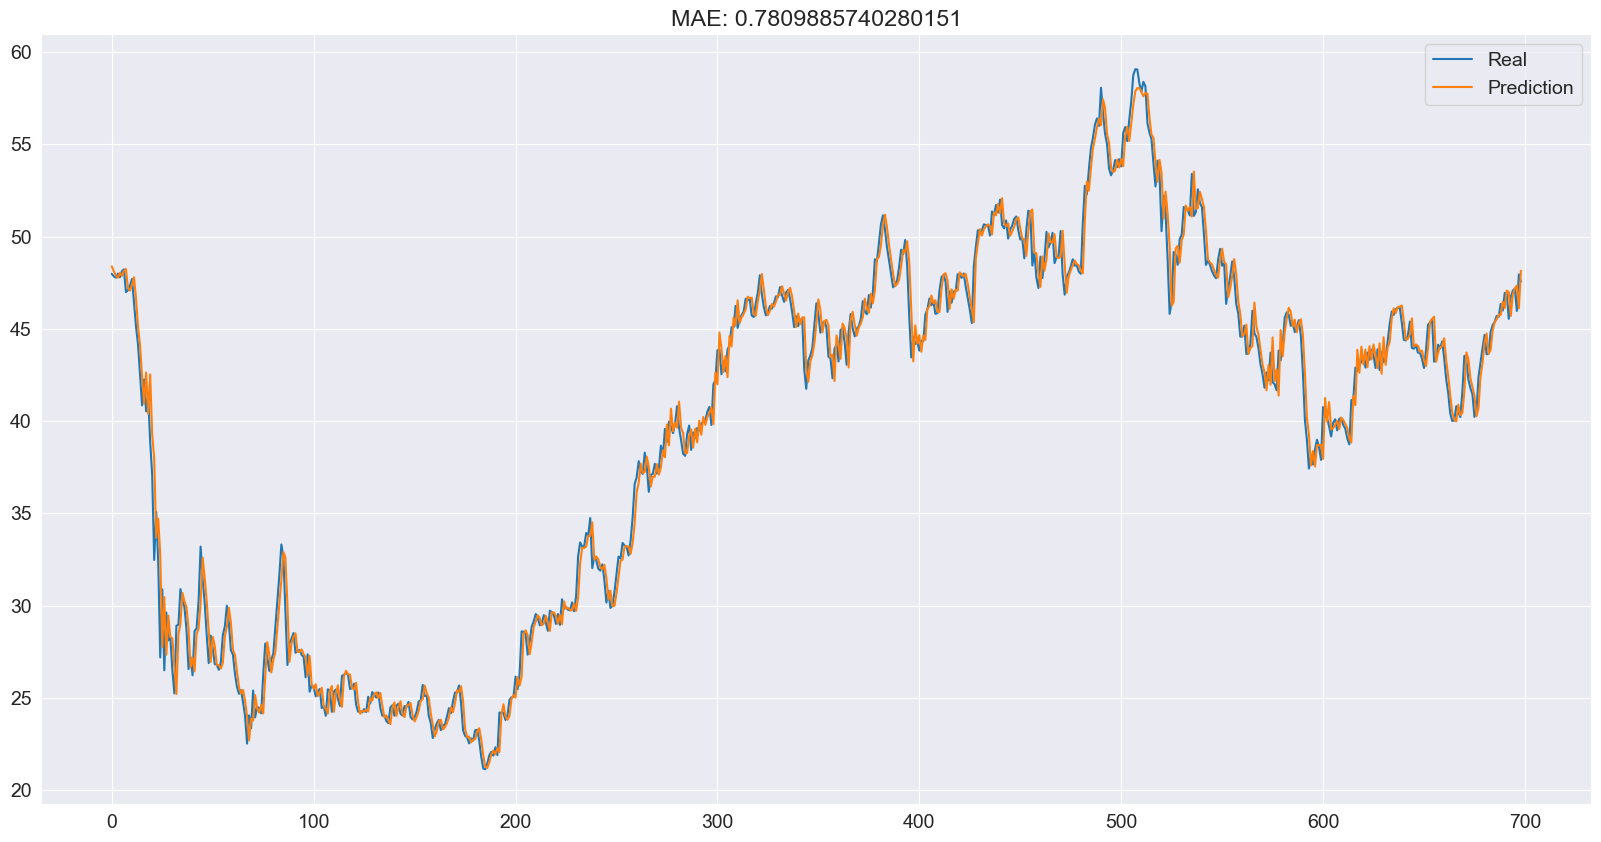

In [46]:
plt.title('MAE: {}'.format(testScore[1]))
plt.plot(Ytest, label='Real')
plt.plot(preds, label='Prediction')

plt.legend(loc="best")

#for saving figures
# plt.savefig('CPALL_graph.png')
plt.show()

In [47]:
#denormalizing datasets
# preds = scaler.inverse_transform(preds)
# Ytest = scaler.inverse_transform(Ytest)

In [48]:
#Show Train and Test Scores
print('Train MSE \t Train RMSE \t Train MAE \t Testscore RMSE \tTest MSE \tTest MAE')
print('%.9f \t %.9f \t %.9f \t %.9f \t \t %.9f \t %.9f' % (trainScore[0], math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[0],testScore[1]))

Train MSE 	 Train RMSE 	 Train MAE 	 Testscore RMSE 	Test MSE 	Test MAE
0.405525684 	 0.636808986 	 0.410141319 	 1.065074886 	 	 1.134384513 	 0.780988574


In [49]:
print('MAE \t\t MAPE')
print('%.4f \t\t %.4f' % (mean_absolute_error(Ytest,preds),(np.mean(np.abs((Ytest - preds) / Ytest)) * 100)))

MAE 		 MAPE
0.7810 		 2.0926
